### Nama Lengkap : MOHAMAD ARIF SOFYAN
### User name Dicoding : mohamad_arif_sofyan
### Dataset link : https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

# Import Library

In [2]:
!pip install -q kaggle
!pip install split-folders

In [22]:
from google.colab import files
import os
import splitfolders
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import MobileNetV2, InceptionResNetV2
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

# Pengaturan Kaggle API untuk Mengunduh Dataset

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arifsofyan","key":"c8fbb05f0d20cab04fc172bb52da7393"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dan Mengekstrak Dataset

In [6]:
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip -q food11-image-dataset.zip -d dataset

 99% 1.08G/1.08G [00:15<00:00, 49.0MB/s]
100% 1.08G/1.08G [00:15<00:00, 73.5MB/s]


# Mengeksplorasi Dataset

In [7]:
train = {}
val = {}
eval = {}

path = "/content/dataset"

path_training = os.path.join(path, "training")
for i in os.listdir(path_training):
    train[i] = os.listdir(os.path.join(path_training, i))

path_validasi = os.path.join(path, "validation")
for i in os.listdir(path_validasi):
    val[i] = os.listdir(os.path.join(path_validasi, i))

path_evaluation = os.path.join(path, "evaluation")
for i in os.listdir(path_evaluation):
    eval[i] = os.listdir(os.path.join(path_evaluation, i))

In [8]:
total_train_images = sum(len(images) for images in train.values())
print(f"Total jumlah gambar dalam data training: {total_train_images}")

total_val_images = sum(len(images) for images in val.values())
print(f"Total jumlah gambar dalam data validation: {total_val_images}")

total_eval_images = sum(len(images) for images in eval.values())
print(f"Total jumlah gambar dalam data evaluation: {total_eval_images}")

Total jumlah gambar dalam data training: 9866
Total jumlah gambar dalam data validation: 3430
Total jumlah gambar dalam data evaluation: 3347


# Dataset Splitting

In [9]:
input_folder = "/content/dataset/training"
output_folder = "food_dataset"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)

Copying files: 9866 files [00:02, 3835.07 files/s]


In [10]:
path_train = "/content/food_dataset/train"
path_test = "/content/food_dataset/val"

def explore_data(path):
    data = {}
    for category in os.listdir(path):
        data[category] = os.listdir(os.path.join(path, category))
    return data

train_data = explore_data(path_train)
test_data = explore_data(path_test)

def print_image_count(data, data_type):
    total_images = sum(len(images) for images in data.values())
    print(f"Total jumlah gambar dalam data {data_type}: {total_images}")
    for category in data:
        print(f"Kategori {category}: {len(data[category])} gambar")

print_image_count(train_data, "latih")
print("\n")
print_image_count(test_data, "uji")

Total jumlah gambar dalam data latih: 7891
Kategori Egg: 788 gambar
Kategori Fried food: 678 gambar
Kategori Bread: 795 gambar
Kategori Dairy product: 343 gambar
Kategori Vegetable-Fruit: 567 gambar
Kategori Soup: 1200 gambar
Kategori Seafood: 684 gambar
Kategori Meat: 1060 gambar
Kategori Rice: 224 gambar
Kategori Dessert: 1200 gambar
Kategori Noodles-Pasta: 352 gambar


Total jumlah gambar dalam data uji: 1975
Kategori Egg: 198 gambar
Kategori Fried food: 170 gambar
Kategori Bread: 199 gambar
Kategori Dairy product: 86 gambar
Kategori Vegetable-Fruit: 142 gambar
Kategori Soup: 300 gambar
Kategori Seafood: 171 gambar
Kategori Meat: 265 gambar
Kategori Rice: 56 gambar
Kategori Dessert: 300 gambar
Kategori Noodles-Pasta: 88 gambar


# Visualisasi Sampel Data

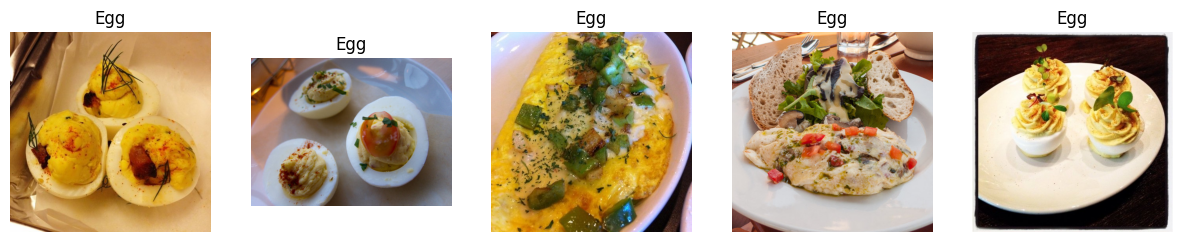

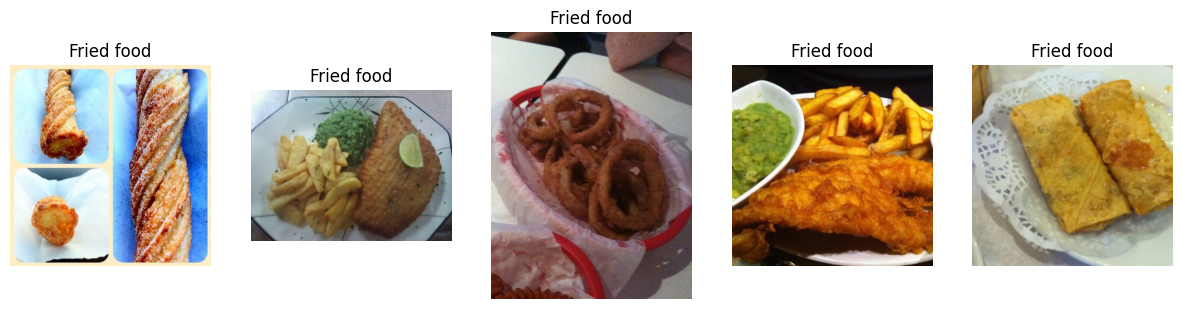

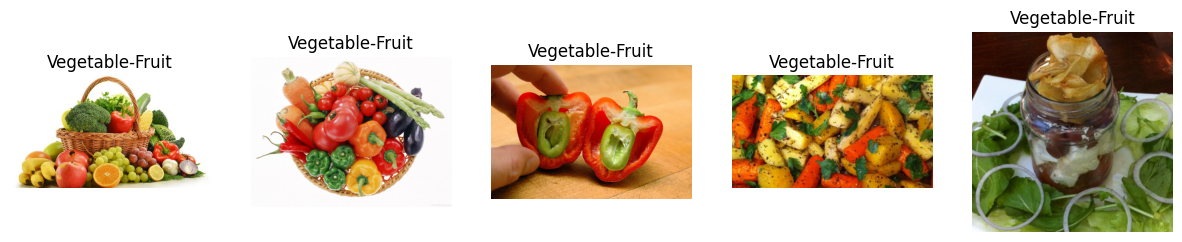

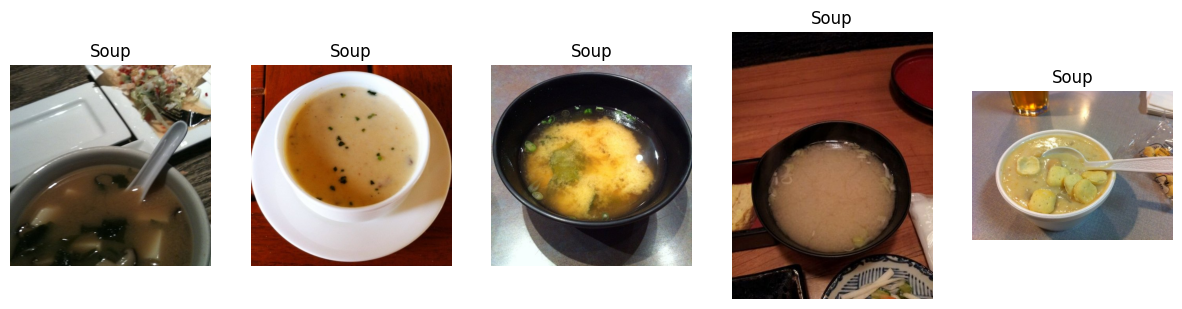

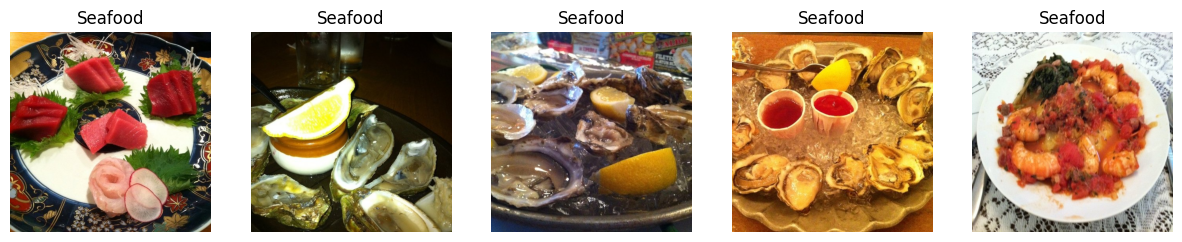

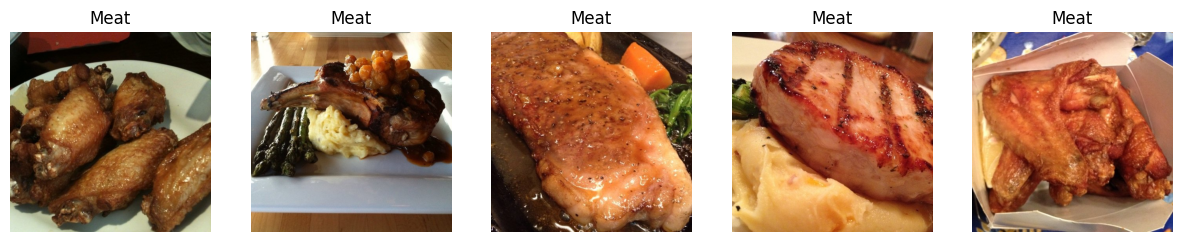

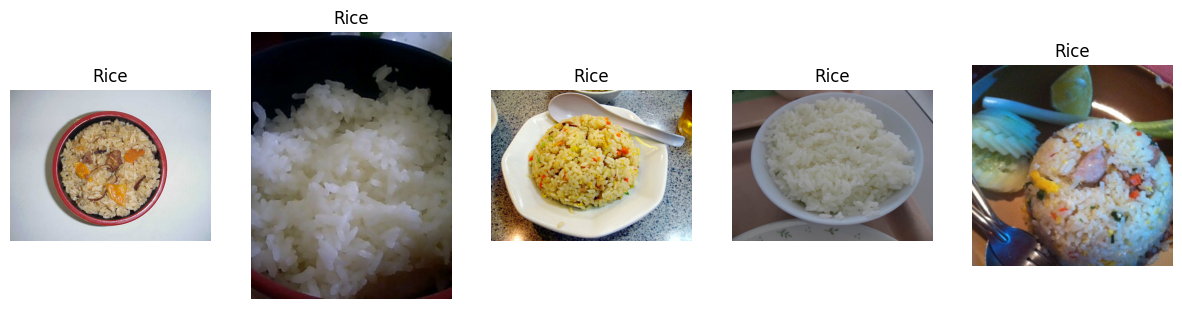

In [11]:
def display_sample_images(data, path, num_images=5):
    for category, images in data.items():
        image_paths = [os.path.join(path, category, img) for img in images[:num_images]]
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(image_paths):
            plt.subplot(1, num_images, i+1)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"{category}")
            plt.axis('off')
        plt.show()

display_sample_images(train_data, path_train)

# Preprocessing Data dan Data Augmentation

In [12]:
TARGET_SIZE = (331, 331)
BATCH_SIZE = 32
EPOCHS = 50

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    path_test,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 7891 images belonging to 11 classes.
Found 1975 images belonging to 11 classes.


# Membangun model sequential dengan Conv2D Maxpooling Layer dan Transfer Learning (InceptionResNetV2)

In [13]:
input_tensor = Input(shape=(331, 331, 3))
base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)
base_model.trainable = True

for layer in base_model.layers:
    layer.trainable = True

model = Sequential([
    base_model,
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(11, activation='softmax')
])

optimizer = Adamax(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

219055592/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 conv2d_203 (Conv2D)         (None, 9, 9, 512)         7078400   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 512)         0         
 g2D)                                                            
                                                                 
 conv2d_204 (Conv2D)         (None, 4, 4, 256)         1179904   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                                                  

In [14]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Callback

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93):
            print("\nMencapai 93% akurasi pada validation set, menghentikan pelatihan!")
            self.model.stop_training = True

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-6, mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
custom_callback = MyCallback()
callbacks_list = [model_checkpoint, early_stopping, reduce_lr, tensorboard, custom_callback]

# Melatih model

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Epoch 1/50
246/246 [==============================] - ETA: 0s - loss: 2.6901 - accuracy: 0.4821
Epoch 1: val_accuracy improved from -inf to 0.78689, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 494s 2s/step - loss: 2.6901 - accuracy: 0.4821 - val_loss: 1.7208 - val_accuracy: 0.7869 - lr: 1.0000e-04
Epoch 2/50
246/246 [==============================] - ETA: 0s - loss: 1.8283 - accuracy: 0.7188
Epoch 2: val_accuracy improved from 0.78689 to 0.84682, saving model to best_model.h5
246/246 [==============================] - 382s 2s/step - loss: 1.8283 - accuracy: 0.7188 - val_loss: 1.4982 - val_accuracy: 0.8468 - lr: 1.0000e-04
Epoch 3/50
246/246 [==============================] - ETA: 0s - loss: 1.5688 - accuracy: 0.7926
Epoch 3: val_accuracy improved from 0.84682 to 0.86834, saving model to best_model.h5
246/246 [==============================] - 388s 2s/step - loss: 1.5688 - accuracy: 0.7926 - val_loss: 1.4067 - val_accuracy: 0.8683 - lr: 1.0000e-04
Epoch 4/50
246/246 [==============================] - ETA: 0s - loss: 1.4423 - accuracy: 0.8361
Epoch 4: val_accuracy improved from 0.86834 to 0.89191, saving model to best_model.h5
246/246

# Visualisasi Akurasi dan Loss

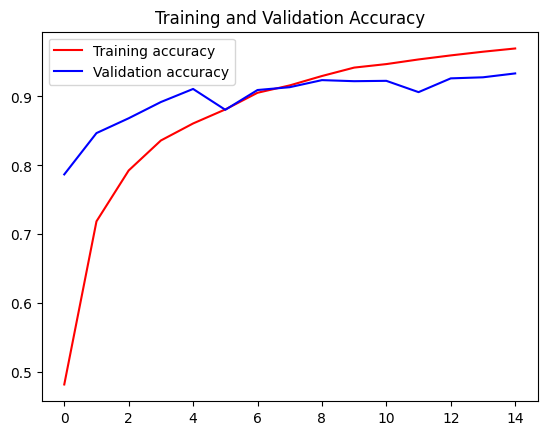

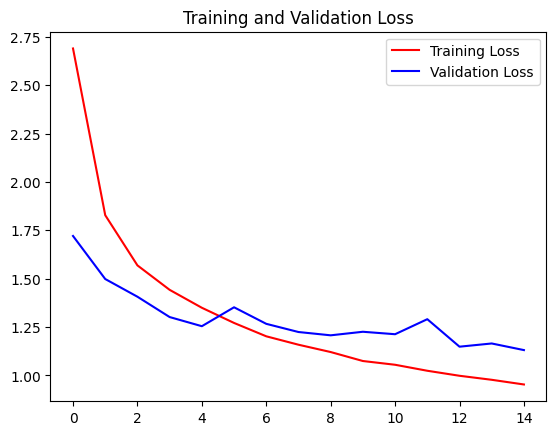

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Evaluasi

In [20]:
train_eval_result = model.evaluate(train_generator, verbose=1)

train_accuracy = train_eval_result[1]
train_loss = train_eval_result[0]

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Training Loss: {train_loss:.4f}')

eval_result = model.evaluate(validation_generator, verbose=1)

accuracy = eval_result[1]
loss = eval_result[0]

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Validation Loss: {loss:.4f}')

247/247 [==============================] - 255s 1s/step - loss: 0.8934 - accuracy: 0.9942
Training Accuracy: 99.42%
Training Loss: 0.8934
62/62 [==============================] - 25s 402ms/step - loss: 1.1299 - accuracy: 0.9332
Validation Accuracy: 93.32%
Validation Loss: 1.1299


62/62 [==============================] - 35s 502ms/step


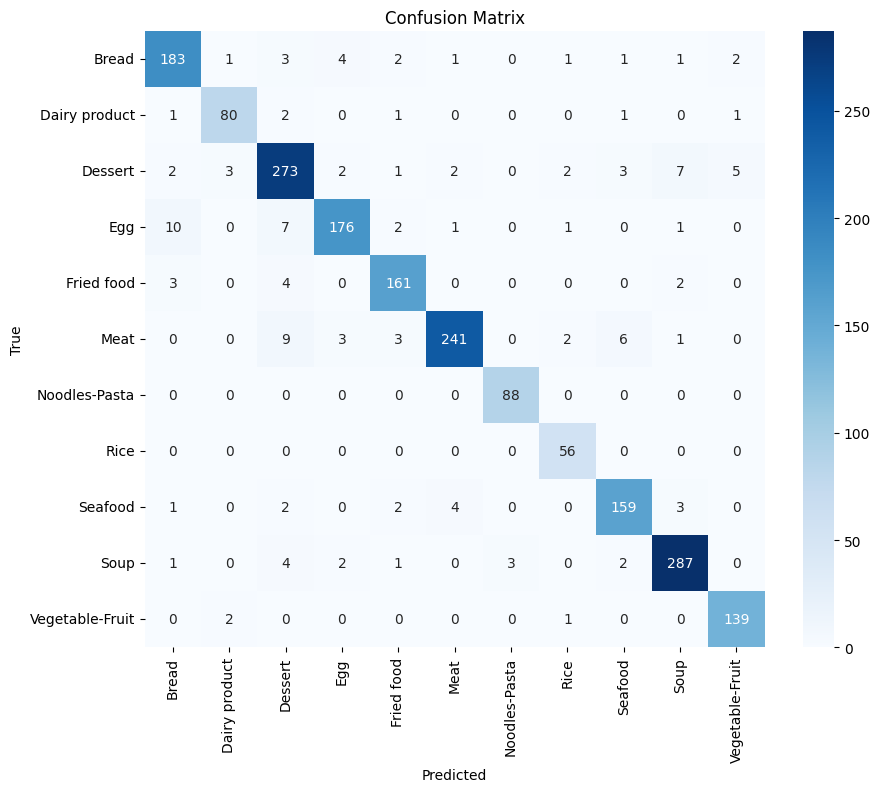

Classification Report:
                  precision    recall  f1-score   support

          Bread       0.91      0.92      0.91       199
  Dairy product       0.93      0.93      0.93        86
        Dessert       0.90      0.91      0.90       300
            Egg       0.94      0.89      0.91       198
     Fried food       0.93      0.95      0.94       170
           Meat       0.97      0.91      0.94       265
  Noodles-Pasta       0.97      1.00      0.98        88
           Rice       0.89      1.00      0.94        56
        Seafood       0.92      0.93      0.93       171
           Soup       0.95      0.96      0.95       300
Vegetable-Fruit       0.95      0.98      0.96       142

       accuracy                           0.93      1975
      macro avg       0.93      0.94      0.94      1975
   weighted avg       0.93      0.93      0.93      1975



In [18]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print('Classification Report:\n', class_report)

# Menyimpan Model ke dalam Format TF-Lite:

In [19]:
export_dir = 'saved_model_food/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = 'food.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print(f'Model berhasil diubah menjadi {tflite_model_file}')

Model berhasil diubah menjadi food.tflite


# Extract Folder Model ke zip

In [23]:
export_dir = 'saved_model_food/'
zip_path = '/content/saved_model_food.zip'
shutil.make_archive('/content/saved_model_food', 'zip', export_dir)

'/content/saved_model_food.zip'